<a href="https://colab.research.google.com/github/ziuom/ziuom/blob/main/%EA%B9%80%EC%A7%80%EC%9B%90_%EC%BC%80%EB%9D%BC%EC%8A%A4%EB%94%A5%EB%9F%AC%EB%8B%9D_pizza__vs_icecream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle --upgrade

In [ ]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d hemendrasr/pizza-vs-ice-cream

Dataset URL: https://www.kaggle.com/datasets/hemendrasr/pizza-vs-ice-cream
License(s): other
 96% 40.0M/41.7M [00:03<00:00, 15.0MB/s]
100% 41.7M/41.7M [00:03<00:00, 13.1MB/s]


In [ ]:
import zipfile

with zipfile.ZipFile('/content/pizza-vs-ice-cream.zip', 'r') as zip_ref:
    zip_ref.extractall('pizza_cream')

In [ ]:
import os #파일 시스템 관련 기능을 제공하는 파이썬 모듈
import math #수학적인 함수/상수를 제공하는 모듈
import numpy as np #다차원 배열을 다루는 NumPy
import matplotlib.pyplot as plt #데이터 시각화를 위한 Matplotlib의 pyplot 모듈
import tensorflow as tf #딥러닝 모델을 구축/학습하는 TensorFlow
import tensorflow_hub as hub #사전 훈련된 모델을 쉽게 사용할 수 있는 TensorFlow Hub
from tensorflow.keras import layers #신경망의 층을 쌓을 Keras API의 레이어 모듈

print(tf.__version__)

2.15.0


In [ ]:
train_dir = '/content/pizza_cream/dataset/train'
val_dir = '/content/pizza_cream/dataset/valid'
test_dir = '/content/pizza_cream/dataset/test'

In [ ]:
BATCH_SIZE=32
IMG_SIZE = 480

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,         #모든 이미지의 픽셀 값을 0~1범위로 스케일링 = 학습 안정화를 위함
    rotation_range=40,      #이미지를 0~40도 범위 내로 임의로 회전
    width_shift_range=0.2,  #이미지를 가로로 최대 20%까지 임의로 이동
    height_shift_range=0.2, #이미지를 세로로 최대 20%까지 임의로 이동
    shear_range=0.2,        #이미지를 엇갈리도록 변환
    zoom_range=0.2,         #이미지를 최대 20%까지 임의로 확대 혹은 축소
    fill_mode='nearest',    #이미지를 변환할 때 생기는 빈 공간을 채움
                            # ㄴ> (가장 가까운 픽셀 값 이용)
    horizontal_flip=True,)  #이미지를 수평으로 뒤집음


train_generator = train_datagen.flow_from_directory(
    train_dir,                          #훈련 데이터셋이 저장된 디렉토리 경로
    target_size=(IMG_SIZE, IMG_SIZE),   #모든 이미지를 480, 480 크기로 조정
    batch_size=BATCH_SIZE,              #배치 크기를 32로 설정
    class_mode='binary')                #이진 분류
                                        # ㄴ> (pizza 혹은 ice cream 클래스 중 하나로 분류)


Found 718 images belonging to 2 classes.


In [ ]:
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 208 images belonging to 2 classes.


In [ ]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 106 images belonging to 2 classes.


In [ ]:
def plot_grid_images(images, labels, columns=5, image_size=None, figsize=(8, 8), cmap='gray', title=None, file_name=None):
    fig = plt.figure(figsize=figsize)
    fig.tight_layout(h_pad=3)
    rows = math.ceil(len(images)/columns)
    for image, label, position in zip(images, labels, range(1, len(labels)+1)):
        fig.add_subplot(rows, columns, position)
        if image_size is not None:
            image = image.reshape(image_size)

        plt.imshow(image, cmap=cmap, interpolation='nearest')
        plt.axis('off')
        plt.title(label)
    if title is not None:
        fig.suptitle(title, fontsize=14)

    if file_name is not None:
        plt.savefig(file_name)
    plt.show()
    return file_name


def show_examples(generator, no_labels=False, title=None, no_images_to_show=9, columns=3):
    images_to_show = []
    images_labels = []
    images_shape = None

    if no_labels:
        for images in generator:
            images_shape = images.shape[1:]
            images_to_show.extend(images)
            if len(images_to_show) >= no_images_to_show:
                break
        images_labels = [None for _ in range(no_images_to_show)]
    else:
        class_indices = {index: label for label, index in generator.class_indices.items()}
        for images, labels in generator:
            images_shape = images.shape[1:]
            images_to_show.extend(images)
            images_labels.extend([class_indices[index] for index in labels])
            if len(images_to_show) >= no_images_to_show:
                break

    print('IMAGE SHAPE: ', images_shape)
    plot_grid_images(images_to_show[:no_images_to_show], images_labels[:no_images_to_show], title=title, columns=columns)

IMAGE SHAPE:  (480, 480, 3)


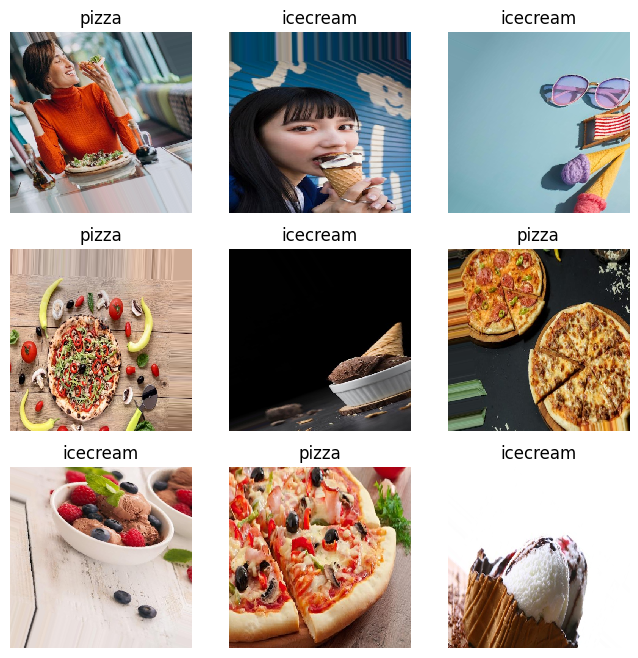

In [ ]:
show_examples(train_generator)

IMAGE SHAPE:  (480, 480, 3)


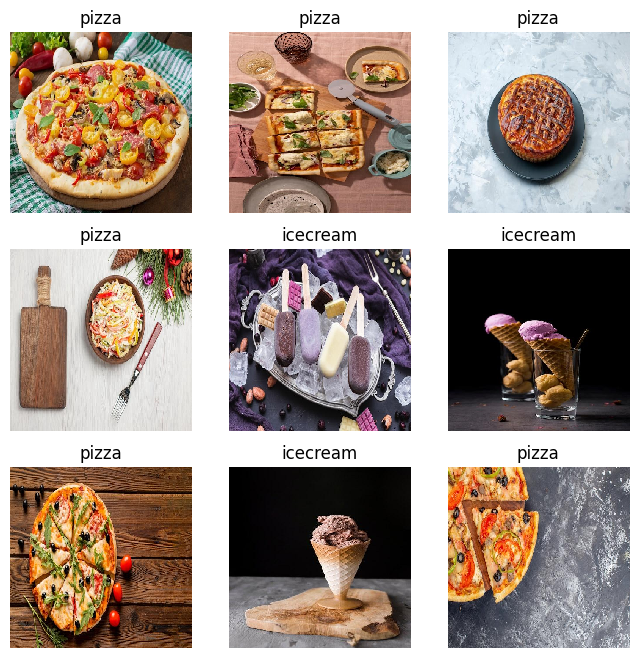

In [ ]:
show_examples(val_generator)

IMAGE SHAPE:  (480, 480, 3)


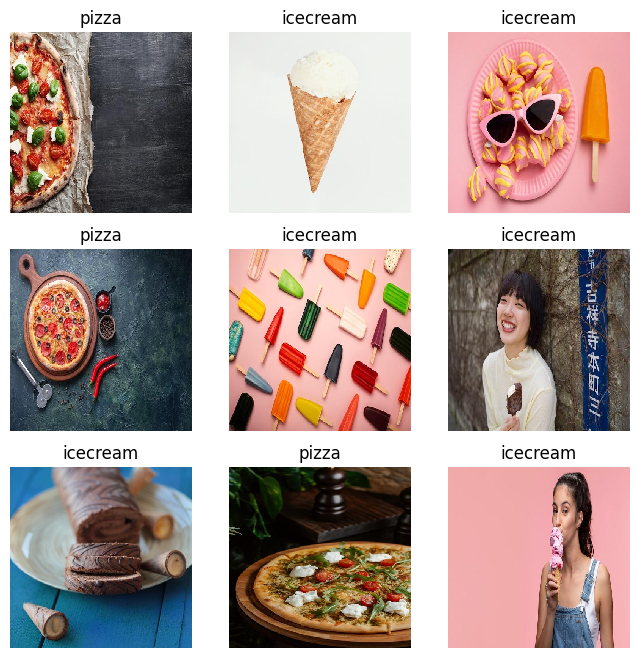

In [ ]:
show_examples(test_generator)

In [ ]:
#이미 있는 모델 사용

FEATURE_EXTRACTOR_URL = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/2'

In [ ]:
model = tf.keras.Sequential([
    hub.KerasLayer(FEATURE_EXTRACTOR_URL, trainable=False, input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
SAVED_MODEL_PATH = './ckpt/pizza_vs_icecream_model.h5'

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    SAVED_MODEL_PATH,
    monitor='val_loss',
    save_best_only=True
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5
)

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[model_checkpoint, early_stopping]
)

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
saved_model = tf.keras.models.load_model(
    SAVED_MODEL_PATH,
    custom_objects={'KerasLayer': hub.KerasLayer}
)

In [ ]:
saved_model.evaluate(test_generator)